## Postprocessing

In this notebook, we will highlight the main quality metrics and the major sanity checks that should be done while performing the manual curation of a spike sorting

In [1]:
import spikeinterface.full as si
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)

Let's take a real openephys recording, and launch a spike sorting pipeline to get the results



In [3]:
from pathlib import Path
oe_folder = Path('/home/pierre/Téléchargements/openephys_recording/2023-08-23_15-56-05')
recording = si.read_openephys(oe_folder)

import probeinterface as pi
from probeinterface.plotting import plot_probe
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H5'
probe = pi.get_probe(manufacturer, probe_name)
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')
recording = recording.set_probe(probe)

recording_f = si.highpass_filter(recording, freq_min=150, dtype='float32')
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f)
print("Some bad channels are detected", bad_channel_ids)
recording_f = recording_f.remove_channels(bad_channel_ids)
recording_f = si.common_reference(recording_f)
print(recording_f)

results = si.run_sorter('spykingcircus2', recording_f, verbose=True, apply_preprocessing=False)

Some bad channels are detected ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH40' 'CH57' 'CH58'
 'CH59' 'CH60' 'CH61' 'CH62' 'CH63' 'CH64']
CommonReferenceRecording: 47 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                          300.00s (5.00 minutes) - float32 dtype - 1.58 GiB
detect peaks using locally_exclusive with n_jobs = 20 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 95585 peaks in total
We kept 95585 peaks for clustering
extracting features with n_jobs = 20 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

We found 41 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/src/spikeinterface/core/baserecordingsnippets.py:228: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


We kept 38 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 20 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 20 and chunk_size = 3000


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 227578 spikes
spykingcircus2 run time 96.48s


In [4]:
%matplotlib widget
si.plot_traces(recording_f, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

First, we need to obtain the waveforms from the sorting

In [5]:
waveforms = si.extract_waveforms(recording_f, results, mode='memory', sparse=True, **job_kwargs, ms_before=2, ms_after=2)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

# Computing the metrics

We need to compute some metrics on the spikes and waveforms that we have obtained

In [6]:
metrics = si.compute_quality_metrics(waveforms, **job_kwargs)

/home/pierre/github/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:842: UserWarning: Units [1, 2, 23] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
/home/pierre/github/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:696: UserWarning: 
  warnings.warn("")


# Export to phy

For those that are interested, you can simply export to phy via SpikeInterface

In [18]:
si.export_to_phy(waveforms, 'phy', True, True, copy_binary=True, **job_kwargs)
import os
os.system('phy template-gui /home/pierre/data/sorting/nick/dataset1/phy/params.py')

FileExistsError: /home/pierre/data/sorting/nick/dataset1/phy already exists

In [7]:
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv,sync_spike_2,sync_spike_4,sync_spike_8,firing_range
0,13111.0,43.703333,1.0,3.240045,2.422944,4165.0,1.0,4177.0,NaN,0.001114,19.143833,NaN,0.043551,0.000000,0.0,25.66
1,443.0,1.476667,1.0,25.408899,1.528670,3.0,1.0,1.0,NaN,NaN,177.736893,NaN,0.072235,0.000000,0.0,2.21
2,487.0,1.623333,1.0,16.025265,2.951482,7.0,1.0,3.0,NaN,NaN,103.406158,NaN,0.098563,0.000000,0.0,2.00
3,1371.0,4.570000,1.0,5.758831,6.384198,120.0,1.0,108.0,NaN,0.000755,39.555744,NaN,0.097009,0.000729,0.0,4.00
4,4577.0,15.256667,1.0,9.719082,0.844912,177.0,1.0,213.0,0.34,0.002689,73.929016,NaN,0.039327,0.000218,0.0,4.24
5,3313.0,11.043333,1.0,8.116646,8.281729,909.0,1.0,952.0,NaN,0.005262,47.204792,NaN,0.076668,0.000000,0.0,10.82
6,7922.0,26.406667,1.0,6.657849,4.045694,2539.0,1.0,2773.0,NaN,0.003369,36.223755,NaN,0.083817,0.000000,0.0,14.11
7,2071.0,6.903333,1.0,3.276911,3.963590,170.0,1.0,108.0,NaN,0.001881,19.805931,NaN,0.063737,0.000483,0.0,6.62
8,4604.0,15.346667,1.0,4.403025,1.858770,394.0,1.0,284.0,NaN,0.014632,26.602648,NaN,0.056255,0.000000,0.0,8.69
9,13642.0,45.473333,1.0,4.069323,2.021986,3763.0,1.0,4055.0,NaN,0.003137,23.045109,NaN,0.035332,0.000000,0.0,22.95


# Slicing your results

You can easily obtain some units by combining some quality metrics

In [9]:
## Get unit_ids
good_units_ids = metrics.query('snr > 5 & isi_violations_ratio < 0.1').index
print(good_units_ids)

Index([23], dtype='int64')


In [10]:
bad_units_ids = metrics.query('isi_violations_ratio > 1').index

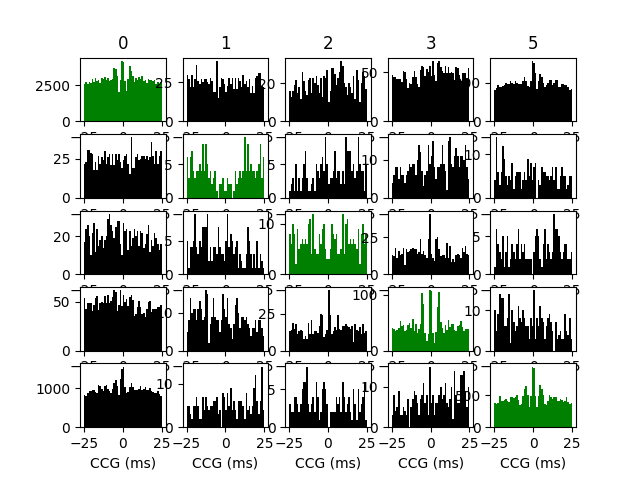

In [12]:
si.compute_correlograms(waveforms)
si.plot_crosscorrelograms(waveforms, bad_units_ids[:5])

# Auto merge (Lussac module)

Eventually, you can have a list of putative merges that should be done (and could be done)

In [13]:
si.get_potential_auto_merge(waveforms)

[]

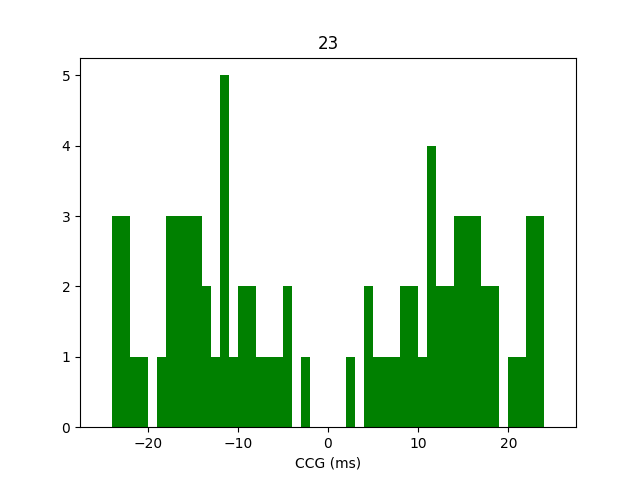

In [14]:
si.plot_crosscorrelograms(waveforms, good_units_ids[:5])

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

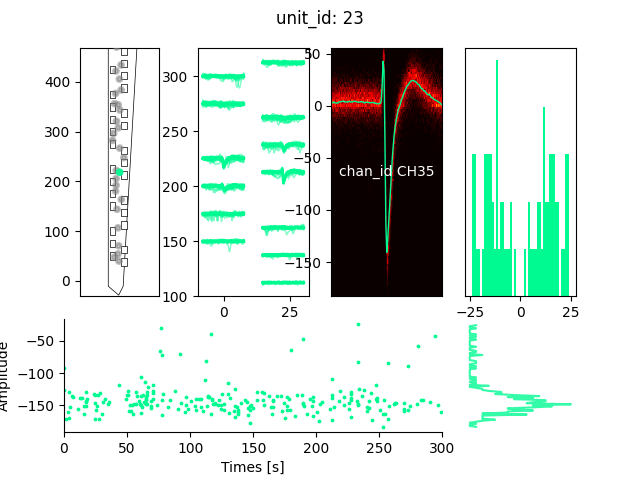

In [15]:
si.compute_unit_locations(waveforms)
si.compute_spike_amplitudes(waveforms, **job_kwargs)
si.plot_unit_summary(waveforms, good_units_ids[0])

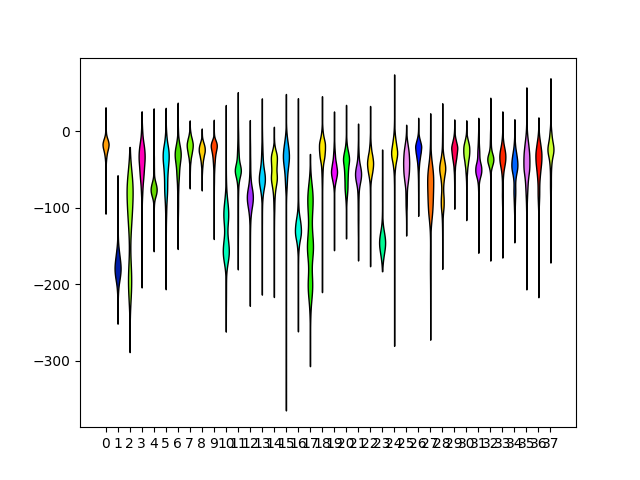

In [16]:
si.plot_all_amplitudes_distributions(waveforms)

In [17]:
%matplotlib widget
si.plot_unit_templates(waveforms, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…